In [296]:
%matplotlib notebook
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

# Utilities

In [352]:
def calc_acceleration_alt(r, n, d, G, m, **unused):
    a = np.zeros([n, d])
    
    # For all indicies where j!=i, summing over js
    # j is row index, i is column
    #a = G*m*r/np.norm(r)
    
    num = r[np.newaxis] - r[:,np.newaxis] # 
    den = spatial.distance.pdist(r)**3 # Returns pairwise distances
    
    den = np.triu(den)
    
    n_choose_2 = n*(n - 1)/2
    a = G*m*(num/den)
    
    return a

In [351]:
def calc_acceleration(r, n, d, G, m, **unused):
    # For loop version to base work off of
    a = np.zeros([n, d])
    
    # For all indicies where j!=i, summing over js
    # j is row index, i is column    
    for i in range(n):
        for j in range(n):
            if i != j:
                r_norm = np.linalg.norm(r[j]-[i])
                #r_norm = np.sqrt((r[j][0]-r[i][0])**2 + (r[j][1]-r[i][1])**2)
                a[i][0] += G*m[j] * (r[j][0]-r[i][0])/r_norm**3
                a[i][1] += G*m[j] * (r[j][1]-r[i][1])/r_norm**3
                
    return a

In [121]:
def calc_jerk():
    # Calculate jerk
    jerk = 0
    for i in range(n):
        j = i + 1
        rij = r
        vij = 1
        jerk += G*m[j]*(())

In [441]:
def calc_energy(r, v, n, G, m, **unused):
    E = 0
    for i in range(n):
        E += ((m[i]*(v[i]@v[i]))**2)/(2*m[i])
        for j in range(i+1, n):
            dist = np.linalg.norm(r[i]-[j])
            E -= G*m[i]*m[j]/dist
    return E

In [480]:
def calc_angular_momentum(r, v):
    j = np.cross(r, v)
    if np.shape(r)[1] == 2: # numpy.cross returns a float if both vectors are 2D (ex. 3x2)
        j = [np.array([0, 0, i]) for i in j] # we need to do j cross v later, so need to put back in a vector
    return np.array(j)

In [500]:
def calc_runge_lenz(r, v, j, m, G, d, **unused):
    # The abs value of this is the eccentricity
    """print("np.cross(v, j):")
    print(np.cross(v, j))
    print("r/r: ")
    print(r/np.linalg.norm(r))"""
    print("j: ", j)
    cross = np.cross(v, j)[:, :d] # Remove extra dimension if needed (since j had a z-dimension)
    print("cross: ", cross)
    return (cross/(G*np.sum(m))) - r/np.linalg.norm(r)

In [511]:
def calc_sma(j, e, m, G, n, d, **unused):
    # Returns the semi-major axis calculated with the
    # current position, angular momentums and runge-lenz vector
    print("j: ", j)
    print("e: ", e)
    print("e(new axis): ", e[:,np.newaxis])
    tmp = [np.concatenate(e[i], [0]) for i in range(n)]
    return ((j**2)/(G*np.sum(m))) / (1 - tmp**2)

## Adaptive Timestep

In [16]:
# In exercise 2, everything should initially be done with a fixed timestep, and then re-run
# with an adaptive timestep

def fixed_timestep(P):
    fixed_time_step = (1.0/500)*P       # Time per integration step (FIXED)
    return fixed_time_step

def adaptive_timestep(n):
    pass

# Integration Methods

## Ex1: Euler

In [271]:
def euler(r, v, a, dt, params):
    a = calc_acceleration(r, **params)
    r = r + v*dt
    v = v + a*dt # v = [vx, vy]
    return r, v, a

## Ex1: Euler-Cromer

In [272]:
def euler_cromer(r, v, a, dt, params):
    a = calc_acceleration(r, **params)
    v = v + a*dt
    r = r + v*dt
    return r, v, a

## Ex1: Velocity Verlet

In [273]:
def v_verlet(r, v, a, dt, params):
    v_tmp = v + 0.5*dt*a
    r = r + dt*v_tmp
    a = calc_acceleration(r, **params)
    v = v_tmp + 0.5*dt*a
    return r, v, a

## Ex1: RK4

In [375]:
def rk4_helper(X, params):
    r, v = X
    a = calc_acceleration(r, **params)
    return np.array([v, a])

def rk4(r, v, a, dt, params):
    # We want to find K values for r and v simultaneously, so we'll make a vector [r, v]
    X = np.array([r, v])
    
    K1 = dt*rk4_helper(X, params)
    K2 = dt*rk4_helper(X + 0.5*K1, params)
    K3 = dt*rk4_helper(X + 0.5*K2, params)
    K4 = dt*rk4_helper(X + K3, params)
    
    X += (1/6)*(K1 + 2*K2 + 2*K3 + K4)
    r, v = X
    a = calc_acceleration(r, **params)
    
    return r, v, a

# Ex2: Application to the two-body problem

## Setup

In [439]:
def n_body_init(init_r, init_v, params, n, d, G, m):
    """Returns initial values for position, velocity and acceleration
    init_r: list/array of length n containing initial positions (vectors of length d)
    init_v: list/array of length n containing initial velocities (vectors of length d)
    """
    
    r = np.array(init_r)
    v = np.array(init_v)
    
    # MOVE TO CENTER OF MASS SYSTEM
    
    # Instead of m1 and m2, we have the total mass M and the reduced mass mu
    M_total = np.sum(m)
    
    # Set the origin of our system at the center of mass
    rcm = np.zeros(d)
    vcm = np.zeros(d)
    
    # Compute center of mass location
    # Note: R = (1/M)*sum(mi*ri) is the location of the center of mass (ri is the
    # vector with the coordinates of the ith object)
    rcm += (m @ r)/M_total 
    vcm += (m @ v)/M_total
    
    # Vector subtraction to move r, v relative to COM
    r -= rcm
    v -= vcm

    # Initial acceleration
    
    a = calc_acceleration(r, **params)
    
    # Other measured values
    
    E = calc_energy(r, v, **params)
    j = calc_angular_momentum(r, v)
    e = calc_runge_lenz(r, v, j, **params)
    sma = calc_sma(j, e, **params)
        
    return r, v, a, E, j, e, sma

In [427]:
def solve_two_body(integrator):
    # Number of spatial dimensions
    d = 2
    
    # Handle inital values and settings for two bodies
    n = 2               # Number of bodies
    P = 2*np.pi         # Period (given as 2pi)
    t_max = 10*P        # Time at which the integration ends
    G = 1.0

    # Initial values (1=star, 2=planet)
    m1 = 1.0     # Mass
    m2 = 10**-3
    m = np.array([m1, m2])

    e = 0.5     # Eccentricity of orbit
    sma = 1.0     # Semi-major axis
    
    params = {'n':n, 'd':d, 'G':G, 'm':m}
    
    # Initial position and velocity
    x = sma*(1 + e)
    y = 0
    
    vx = 0
    vy = np.sqrt((G*(m[0] + m[1])/sma)*((1-e)/(1+e)))
    
    init_r = [[0,0], [x, y]]
    init_v = [[0,0], [vx, vy]]
    
    r, v, a, E, j, e, sma = n_body_init(init_r, init_v, params, **params)
    dt = fixed_timestep(P)
    
    ts = []     # Time
    rs = []     # Position
    vs = []     # Velocity
    accs = []   # Acceleration
    Es = []     # Energy
    js = []     # Specific angular momentum
    es = []     # Runge-Lenz vector (eccentricity)
    smas = []   # Semi-major axis
    
    # Save initial values
    ts.append(0) 
    rs.append(r)
    vs.append(v)
    accs.append(a)
    Es.append(E)
    js.append(j)
    es.append(e)
    smas.append(sma)
    
    # Run the integrator
    t = 0
    
    prog = tqdm(total = t_max) # Progress bar
    
    start_time = time.time() # Measure how long the integrator takes
    
    while t < t_max:
        r, v, a = integrator(r, v, a, dt, params)
        E = calc_energy(r, v, **params)
        j = calc_angular_momentum(r, v)
        e = calc_runge_lenz(r, v, j, **params)
        sma = calc_sma(j, e, **params)
        t += dt
        
        ts.append(t) 
        rs.append(r)
        vs.append(v)
        accs.append(a)
        Es.append(E)
        js.append(j)
        es.append(e)
        smas.append(sma)
    
        prog.update(1) # increment progress bar
    
    end_time = time.time()
    time_elapsed = end_time - start_time
    
    print("Done!")
    print("Took: " + str(time_elapsed) + " seconds")
    
    ts = np.array(ts)
    rs = np.array(rs)
    vs = np.array(vs)
    accs = np.array(accs)
    Es = np.array(Es)
    js = np.array(js)
    es = np.array(es)
    smas = np.array(smas)
    
    return ts, rs, vs, accs, Es, js, es, smas

In [428]:
#ts, rs, vs, accs , Es, js, es, smas = solve_two_body(euler)
#ts, rs, vs, accs, Es, js, es, smas = solve_two_body(euler_cromer)
#ts, rs, vs, accs, Es, js, es, smas = solve_two_body(v_verlet)
ts, rs, vs, accs, Es, js, es, smas = solve_two_body(rk4)

Done!
Took: 7.1515607833862305 seconds


<IPython.core.display.Javascript object>


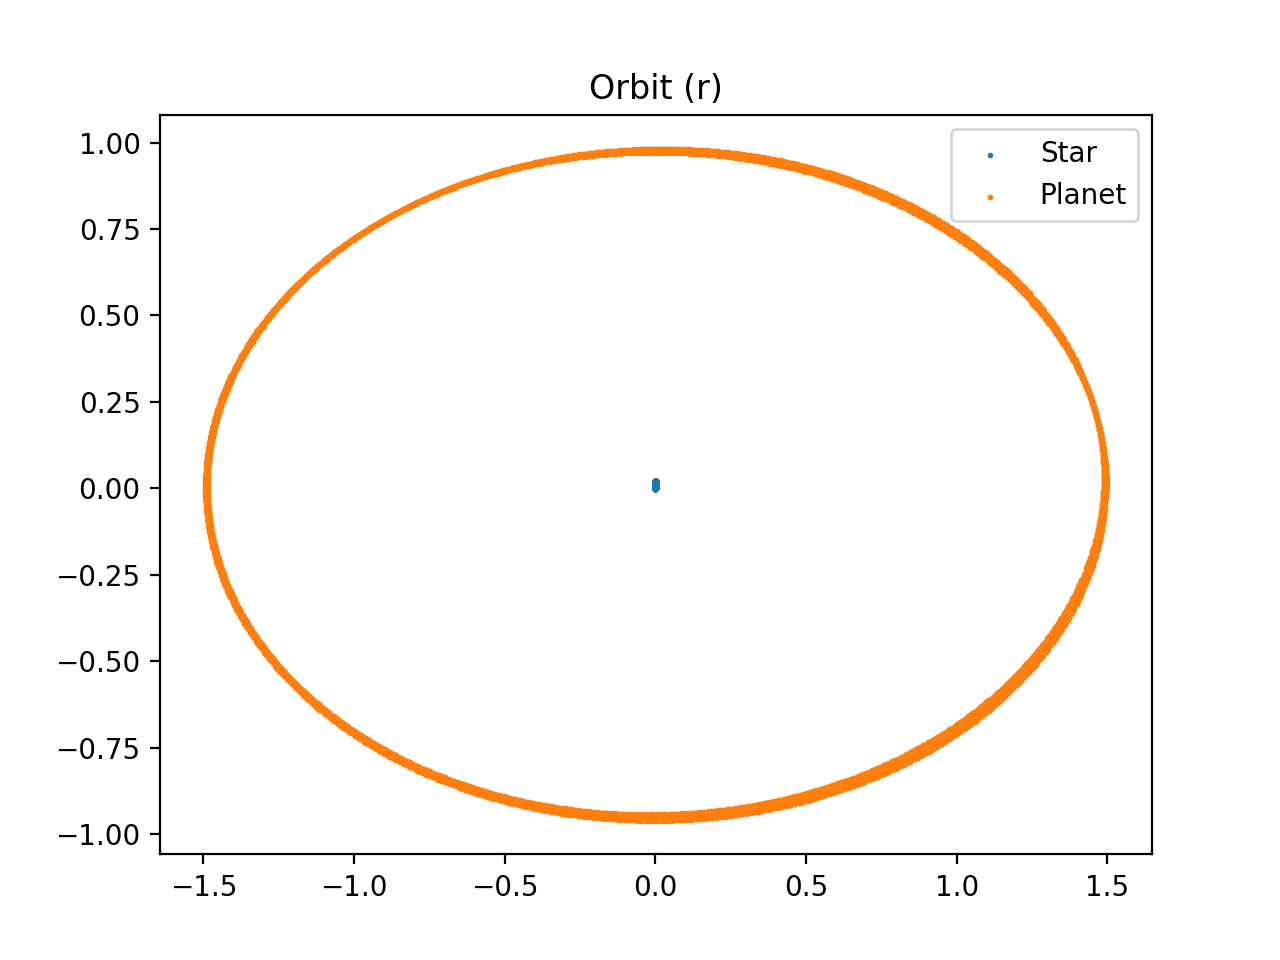

In [429]:
r_fig = plt.figure()
plt.scatter(rs[:,0,0], rs[:,0,1], s=1, label="Star") # SUN --> (x,y)
plt.scatter(rs[:,1,0], rs[:,1,1], s=1, label="Planet") # PLANET --> (x,y)

plt.title("Orbit (r)")
plt.legend()

<IPython.core.display.Javascript object>


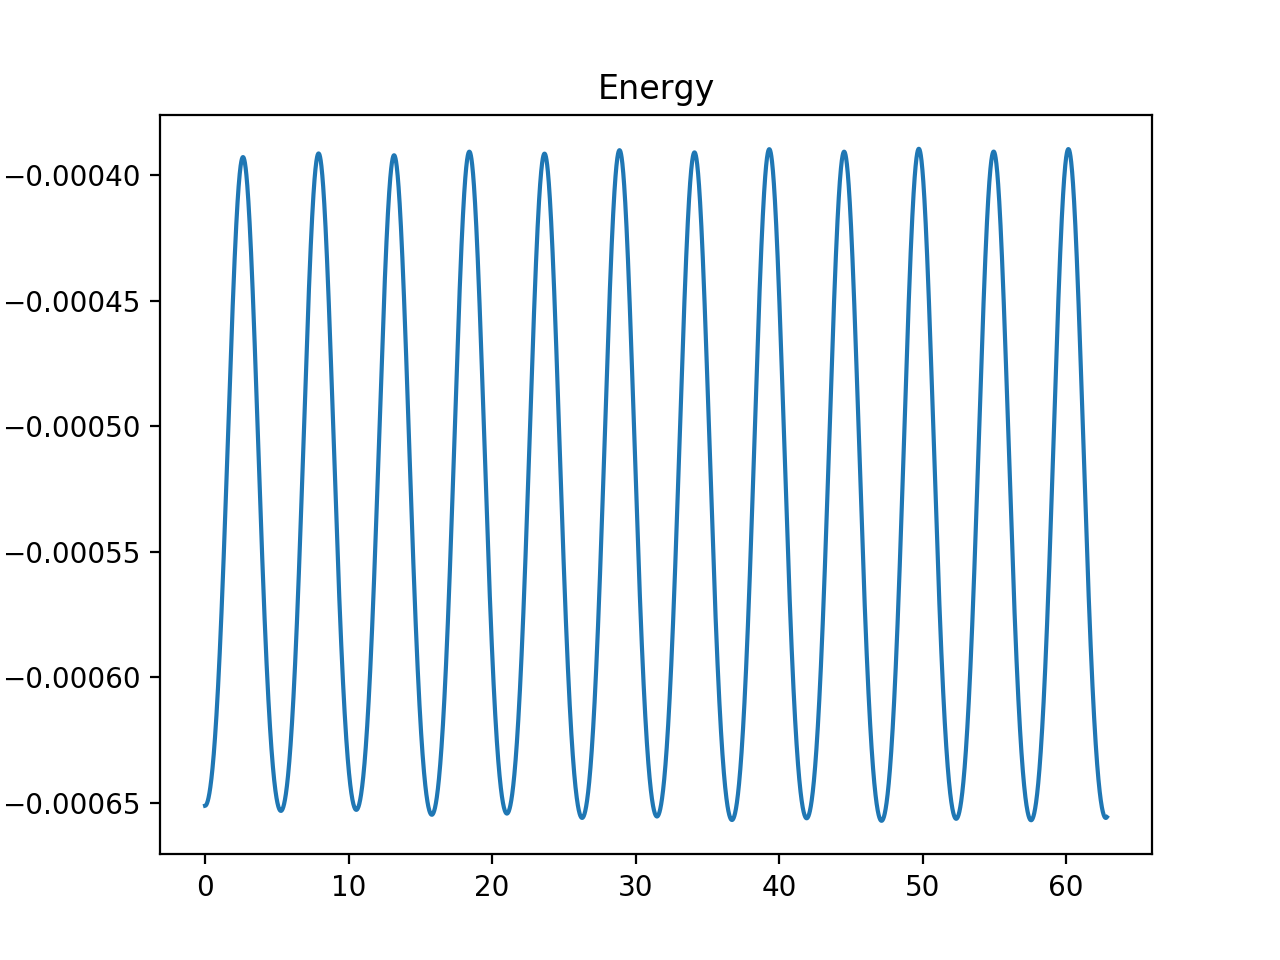

Text(0.5, 1.0, 'Energy')

In [410]:
E_fig = plt.figure()
plt.plot(ts, Es)

plt.title("Energy")

<IPython.core.display.Javascript object>


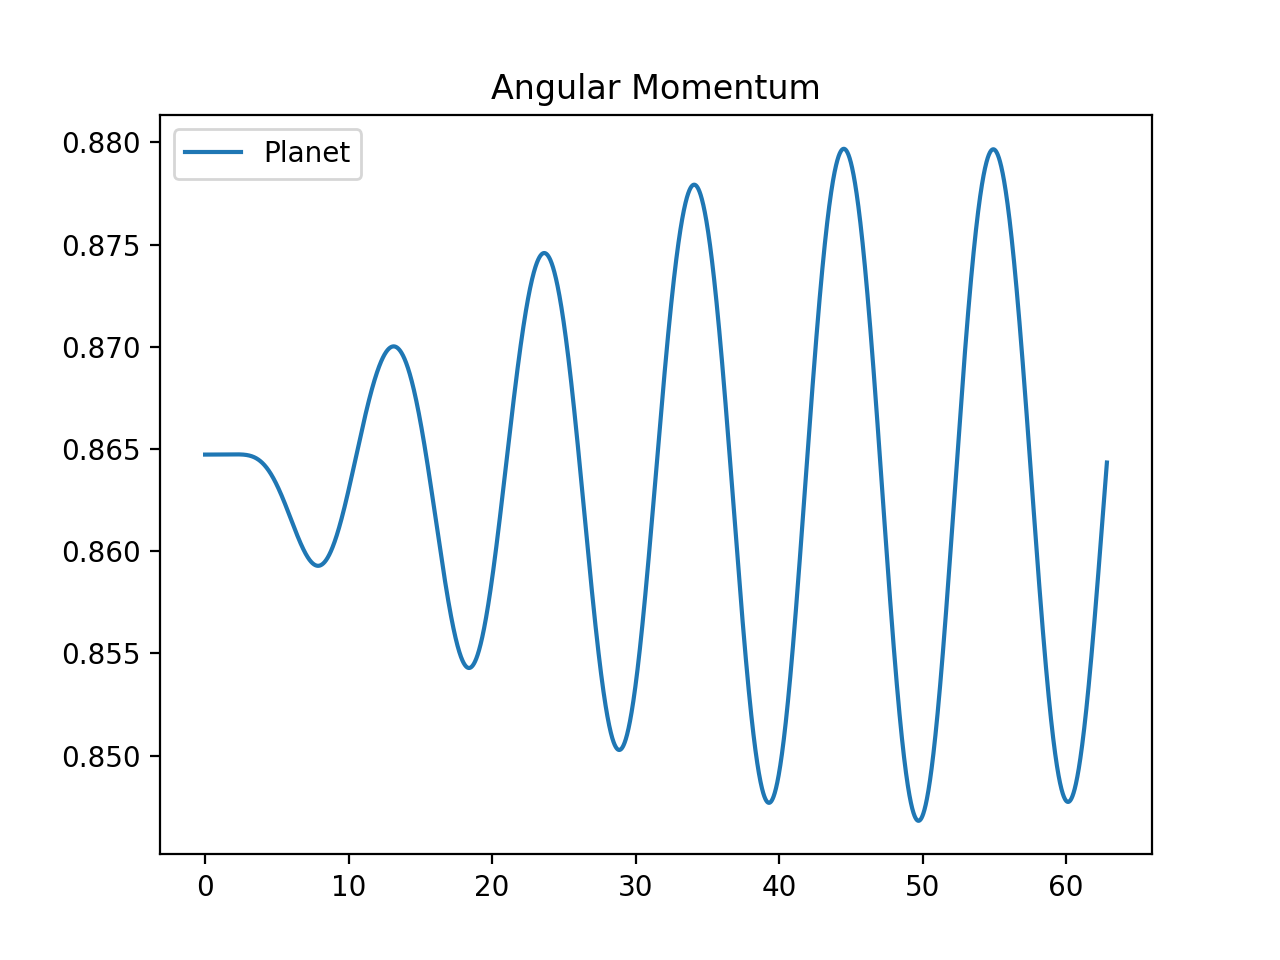

Text(0.5, 1.0, 'Angular Momentum')

In [415]:
j_fig = plt.figure()
plt.plot(ts, js[:,1], label="Planet")

plt.legend()
plt.title("Angular Momentum")

<IPython.core.display.Javascript object>


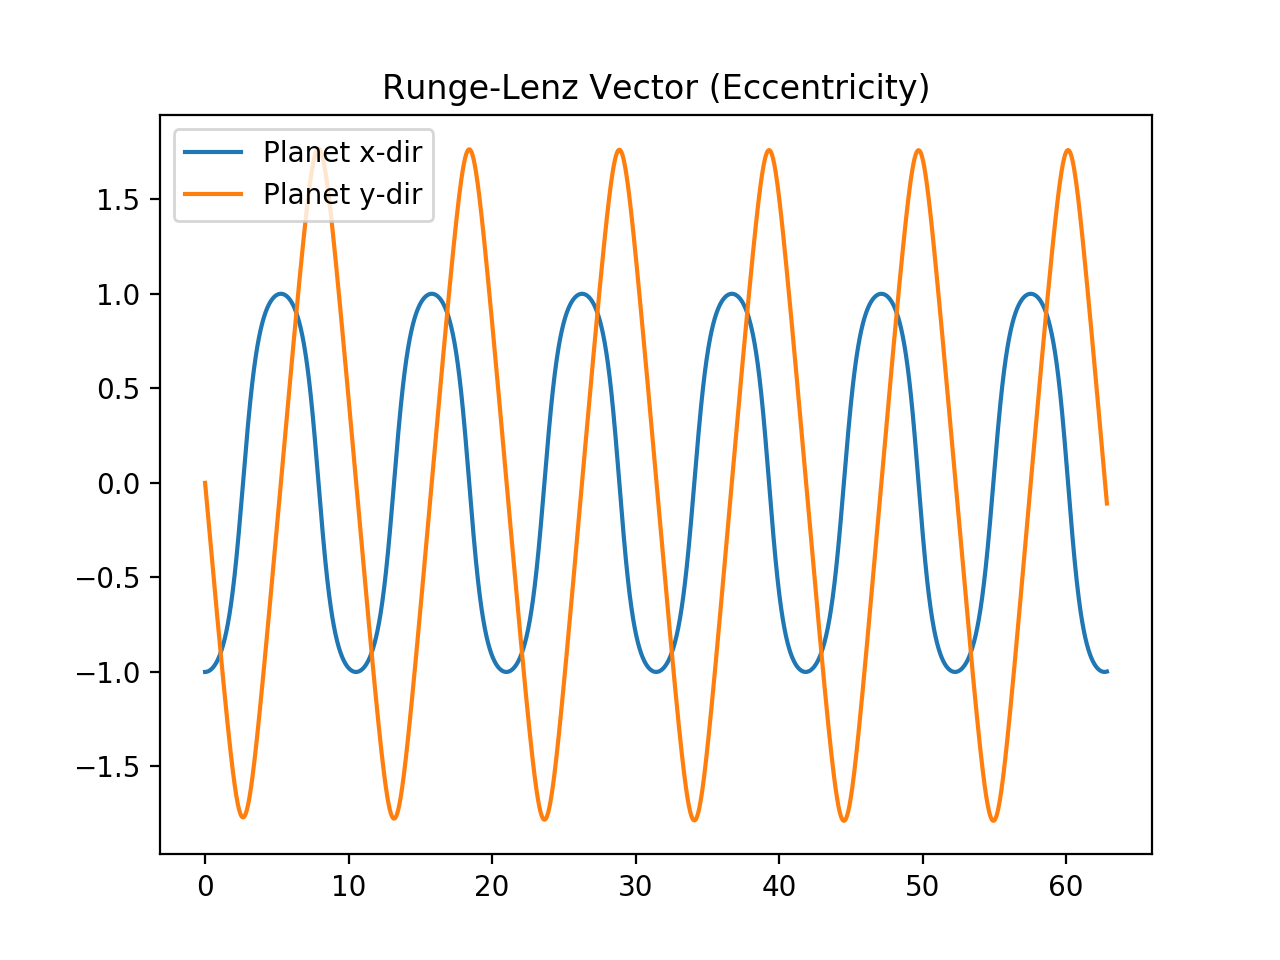

Text(0.5, 1.0, 'Runge-Lenz Vector (Eccentricity)')

In [421]:
e_fig = plt.figure()
plt.plot(ts, es[:,1,0], label="Planet x-dir")
plt.plot(ts, es[:,1,1], label="Planet y-dir")

plt.legend()
plt.title("Runge-Lenz Vector (Eccentricity)")

<IPython.core.display.Javascript object>


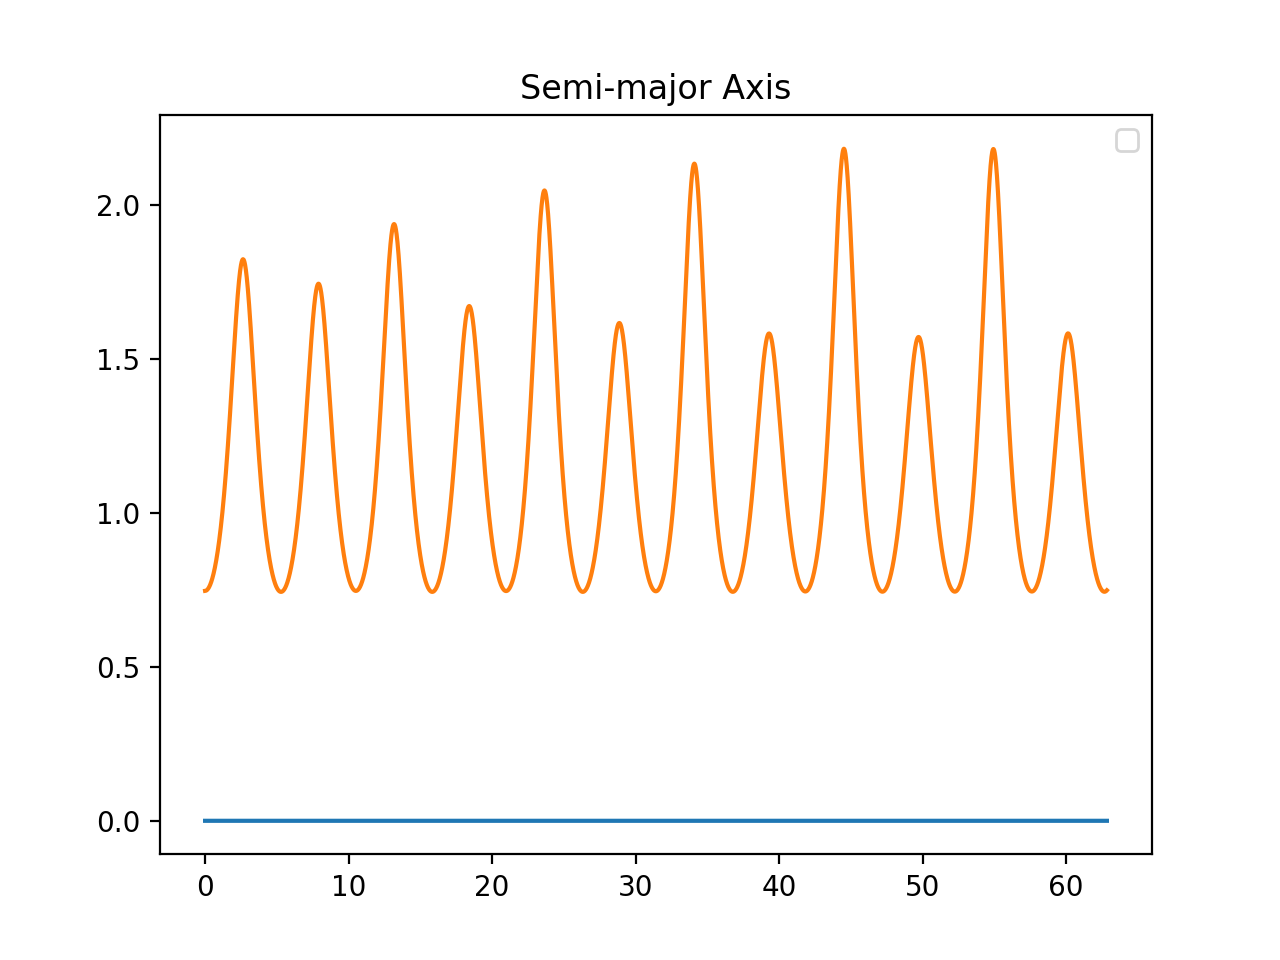

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Semi-major Axis')

In [424]:
e_fig = plt.figure()
plt.plot(ts, smas[:,0])

plt.legend()
plt.title("Semi-major Axis")

In [423]:
np.shape(smas)

(5002, 2, 2)

In [513]:
smas[0]

array([[7.47008232e-13, 7.47007485e-01],
       [7.46264202e-07, 7.47007485e-01]])

In [246]:
vs[:,0,0]

array([5.1109628e-05, 5.1109628e-05, 5.1109628e-05, ..., 5.1109628e-05, 5.1109628e-05, 5.1109628e-05])

In [252]:
np.shape(rs)

(5002, 2, 2)

In [250]:
rs[:,1,0]

array([1.71034388, 1.71034388, 1.71034388, ..., 1.71034388, 1.71034388, 1.71034388])

In [265]:
#rs

Note: The weird values I was seeing were due to accidentally modifying the arrays in-place in the integrator functions.

It turns out that

<code>def foo(arr):
    arr = arr + 3
    return arr
</code>
and

<code>def bar(arr):
    arr += 3
    return arr
</code>

have different behavior. In foo, arr + 3 creates a new array and saves it to "arr". This is because in python, the right hand side is evaluated first and then the left hand side. In bar, the += initiates a call to a built-in adding function, passing arr as an argument. This modifies arr in place. 

In [496]:
def solve_three_body(integrator):
    # Number of spatial dimensions
    d = 2
    
    # Handle inital values and settings for two bodies
    n = 3               # Number of bodies
    P = 2*np.pi         # Period (given as 2pi)
    t_max = 10*P        # Time at which the integration ends
    G = 1.0

    # Initial values (1=star, 2=planet)
    m1 = 1.0     # Mass
    m2 = 10**-3
    m3 = 10**-3
    m = np.array([m1, m2, m3])

    e = 0.5     # Eccentricity of orbit
    sma = 1.0     # Semi-major axis
    
    params = {'n':n, 'd':d, 'G':G, 'm':m}
    
    # Initial position and velocity
    x = sma*(1 + e)
    y = 0
    
    vx = 0
    vy = np.sqrt((G*(m[0] + m[1])/sma)*((1-e)/(1+e)))
    
    init_r = [[0,0], [x, y], [-x, y]]
    init_v = [[0,0], [vx, vy], [-vx, vy]]
    
    r, v, a, E, j, e, sma = n_body_init(init_r, init_v, params, **params)
    dt = fixed_timestep(P)
    
    ts = []     # Time
    rs = []     # Position
    vs = []     # Velocity
    accs = []   # Acceleration
    Es = []     # Energy
    js = []     # Specific angular momentum
    es = []     # Runge-Lenz vector (eccentricity)
    smas = []   # Semi-major axis
    
    # Save initial values
    ts.append(0) 
    rs.append(r)
    vs.append(v)
    accs.append(a)
    Es.append(E)
    js.append(j)
    es.append(e)
    smas.append(sma)
    
    # Run the integrator
    t = 0
    
    prog = tqdm(total = t_max) # Progress bar
    
    start_time = time.time() # Measure how long the integrator takes
    
    while t < t_max:
        r, v, a = integrator(r, v, a, dt, params)
        E = calc_energy(r, v, **params)
        j = calc_angular_momentum(r, v)
        e = calc_runge_lenz(r, v, j, **params)
        sma = calc_sma(j, e, **params)
        t += dt
        
        ts.append(t) 
        rs.append(r)
        vs.append(v)
        accs.append(a)
        Es.append(E)
        js.append(j)
        es.append(e)
        smas.append(sma)
    
        prog.update(1) # increment progress bar
    
    end_time = time.time()
    time_elapsed = end_time - start_time
    
    print("Done!")
    print("Took: " + str(time_elapsed) + " seconds")
    
    ts = np.array(ts)
    rs = np.array(rs)
    vs = np.array(vs)
    accs = np.array(accs)
    Es = np.array(Es)
    js = np.array(js)
    es = np.array(es)
    smas = np.array(smas)
    
    return ts, rs, vs, accs, Es, js, es, smas

In [512]:
ts, rs, vs, accs , Es, js, es, smas = solve_three_body(euler)
#ts, rs, vs, accs, Es, js, es, smas = solve_three_body(euler_cromer)
#ts, rs, vs, accs, Es, js, es, smas = solve_three_body(v_verlet)
#ts, rs, vs, accs, Es, js, es, smas = solve_three_body(rk4)

j:  [[ 0.          0.         -0.        ]
 [ 0.          0.          0.86472885]
 [ 0.          0.         -0.86472885]]
cross:  [[ 0.          0.        ]
 [ 0.49850399 -0.        ]
 [-0.49850399  0.        ]]
j:  [[ 0.          0.         -0.        ]
 [ 0.          0.          0.86472885]
 [ 0.          0.         -0.86472885]]
e:  [[ 0.          0.        ]
 [-0.20959781 -0.        ]
 [ 0.20959781  0.        ]]
e(new axis):  [[[ 0.          0.        ]]

 [[-0.20959781 -0.        ]]

 [[ 0.20959781  0.        ]]]


TypeError: 'list' object cannot be interpreted as an integer

In [446]:
np.shape(j)

NameError: name 'j' is not defined